# Multimodal Financial Research Agent with Hybrid Search
Build an intelligent agent that can search financial documents (RAG) and live market data to provide comprehensive insights.

## Overview

This notebook covers:
- **Hybrid Search (RAG)**: Semantic + keyword search with automatic filter extraction from historical SEC filings
- **Live Finance Research**: Real-time stock data and market information via Yahoo Finance MCP
- **Agent with Dual Tools**: Connect LLM agent with both vector database and live APIs
- **Financial Analysis**: Query historical SEC filings (10-K, 10-Q) and current market data
- **Metadata Filtering**: Automatic extraction of company, year, quarter from queries

## Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

from langchain.agents import create_agent

from langchain.messages import HumanMessage, ToolMessage, AIMessage
from langchain_core.tools import tool

from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3


from scripts.rag_tools import hybrid_search
from scripts.prompts import MULTIMODEL_AGENT_PROMPT

# Initialize the model
# You can use any available model at google ai studio
model = ChatGoogleGenerativeAI(model='gemini-3-flash-preview')

## Define Live Finance Research Tool

In [4]:
import subprocess
import sys

@tool
def live_finance_researcher(query: str) -> str:
    """Research live stock data using Yahoo Finance MCP.
    
    Use this tool to get:
    - Current stock prices and real-time market data
    - Latest financial news
    - Stock recommendations and analyst ratings
    - Option chains and expiration dates
    - Recent stock actions (splits, dividends)
    
    Args:
        query: The financial research question about current market data
        
    Returns:
        Research results from Yahoo Finance
    """
    code = f"""
import asyncio
from scripts.yahoo_mcp import finance_research
asyncio.run(finance_research("{query}"))
"""
    result = subprocess.run([sys.executable, '-c', code], capture_output=True, text=True)
    return result.stdout

## Create Financial Research Agent with Memory

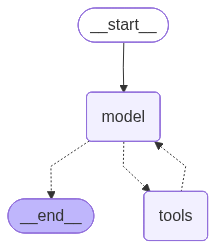

In [5]:
def get_agent():
    conn = sqlite3.connect("data/financial_rag_agent.db", check_same_thread=False)
    checkpointer = SqliteSaver(conn=conn)

    agent = create_agent(
        model=model,
        tools=[hybrid_search, live_finance_researcher],
        system_prompt=MULTIMODEL_AGENT_PROMPT,
        checkpointer=checkpointer
    )

    return agent

agent = get_agent()
agent

In [6]:
config = {"configurable": {"thread_id": "session1"}}

response = agent.invoke(
    {'messages': [HumanMessage("What is Apples's cash flow in 2023?")]},
    config=config
)

response
# print(response['messages'][-1].text)

{'messages': [HumanMessage(content="What is Apples's cash flow in 2023?", additional_kwargs={}, response_metadata={}, id='3f7ae0b1-eb54-43d4-a94e-b68fe9b22e0f'),
  AIMessage(content=[], additional_kwargs={'function_call': {'name': 'hybrid_search', 'arguments': '{"query": "Apple\'s cash flow statement for the fiscal year 2023 10-K"}'}, '__gemini_function_call_thought_signatures__': {'1122a139-839b-4c7b-b3f7-5836066125a7': 'EukDCuYDAXLI2nziPUVGi9aBMxYm2LbILfDqqK794GWgWjO5Do5rOj9+G3DeHrBK44OsFHDy0Pfml4KDjA4zLtI/pUxkUe2N9qBAUsxhrc56/32Ox7wnIw/AfhONEc7/mjytOcvqTRwKvFDizp1Wlg/7Z8Krr04v+0pNsR0mbDAAnyh2fc3y4JVM8Nh2PutQI+0iMj280SuyFh4c2MiUQruF+7kPXBSojUU2feRqhsuhtH5xqUjlioD07RK60dwHKTc1Y4OSKRhjOI/GcdFq8p9e/WhZDxXN38hYCM8EuYg84md2qfrkIMA0C0+HtR90Evo2ARQeSr+VtWRF84qkjbUBbKkdyrfCCKp3TFp+tiSvxgp38aHN7vF9hOMoF47heTquX3kHLPZ0surSRKXn0LQ2NGqTGza9+JKw/ptXb9+yO5WzMuWOKzAa/ykm6oiKjdNwGtMCkDxXDIv3S13g0Tx296nykeZ2B2GrFRSMhL9K28O9YpptoWCPoKlflKsFp/gi38Tr6bqpQ8MPvD+NbnpUGdTXV375IlbuZgxEaYo/tY1GgZMkOKevg+2zq9

## Streaming Helper Function

In [7]:
def stream_agent_response(agent, query, thread_id="default"):

    config = {'configurable': {'thread_id': thread_id}}
    
    for chunk in agent.stream(
        {'messages': [HumanMessage(query)]},
        stream_mode='messages',
        config=config
    ):
        # Extract message from chunk
        message = chunk[0] if isinstance(chunk, tuple) else chunk
        
        # Handle AI messages with tool calls
        if isinstance(message, AIMessage) and message.tool_calls:
            for tool_call in message.tool_calls:
                print(f"\n  Tool Called: {tool_call['name']}")
                print(f"   Args: {tool_call['args']}")
                print()
        
        # Handle tool responses
        elif isinstance(message, ToolMessage):
            print(f"\n  Tool Result (length: {len(message.text)} chars)")
            print()
        
        # Handle AI text responses
        elif isinstance(message, AIMessage) and message.text:
            # Stream the text content
            print(message.text, end='', flush=True)

## Examples

In [8]:
stream_agent_response(agent, "What was Amazon's revenue in Q1 2024?", thread_id="session_1")

Amazon's consolidated revenue (net sales) for the first quarter (Q1) of 2024 was **$143.31 billion**, representing a 13% increase compared to the same period in 2023.

### Segment Revenue Breakdown (Q1 2024)

| Segment | Revenue (in millions) | Year-over-Year Growth |
| :--- | :--- | :--- |
| North America | $86,341 | 12% |
| International | $31,935 | 10% |
| AWS (Cloud) | $25,037 | 17% |
| **Consolidated Total** | **$143,313** | **13%** |

The growth in the North America and International segments was primarily driven by increased unit sales, advertising services, and subscription fees. AWS growth was fueled by increased customer usage.

Source: `amazon 10-q q1 2024.md`, page 25

In [9]:
stream_agent_response(agent, "What is the current stock price of Apple (AAPL) and show me latest news?", thread_id="session_2")


  Tool Called: live_finance_researcher
   Args: {'query': 'What is the current stock price of Apple (AAPL) and the latest news?'}


  Tool Result (length: 2008 chars)

As of the latest market data, the current stock price of **Apple Inc. (AAPL)** is **$271.84**.

### **Latest News for Apple (AAPL):**
*   **Price Target Increase:** Evercore ISI has raised its price target on Apple stock, and Morgan Stanley analysts suggest Apple is positioned to move from an AI "laggard" to a leader by 2026.
*   **Market Sentiment:** Apple is highlighted as one of the ten key stocks currently powering the market, though this concentration is contributing to some "AI bubble" concerns.
*   **Leadership Outlook:** Recent reports discuss upcoming leadership changes at major American icons, including Apple, Walmart, and Berkshire Hathaway.
*   **Tech Sector Trends:** The Nasdaq Composite recently experienced its worst day in nearly four weeks amid a broader tech selloff, which impacted major players like Ap

In [10]:
stream_agent_response(agent, "Compare Microsoft's Q2 2024 revenue from filings with its current stock performance", thread_id="session_3")


  Tool Called: hybrid_search
   Args: {'k': 3, 'query': 'Microsoft 10-Q Q2 2024 revenue for quarter ended December 31 2023'}


  Tool Called: live_finance_researcher
   Args: {'query': 'Microsoft MSFT current stock price performance and analyst ratings 2024'}


  Tool Called: ChunkMetadata
   Args: {'fiscal_quarter': 'q2', 'fiscal_year': '2024', 'company_name': 'microsoft', 'doc_type': '10-q'}


  Tool Result (length: 0 chars)


  Tool Result (length: 1051 chars)


  Tool Called: hybrid_search
   Args: {'k': 5, 'query': 'Microsoft 10-Q revenue quarter ended December 31 2023 fiscal year 2024 q2'}


  Tool Called: live_finance_researcher
   Args: {'query': 'MSFT stock price year to date 2024 performance and current market cap'}


  Tool Called: ChunkMetadata
   Args: {'fiscal_quarter': 'q2', 'fiscal_year': '2024', 'company_name': 'microsoft', 'doc_type': '10-q'}


  Tool Result (length: 0 chars)


  Tool Result (length: 558 chars)


  Tool Called: hybrid_search
   Args: {'k': 10, 'query

In [11]:
stream_agent_response(agent, "Compare Google's revenue between Q1 2024 and Q1 2023", thread_id="session_4")


  Tool Called: hybrid_search
   Args: {'query': 'Alphabet revenue segments Q1 2024 vs Q1 2023'}


  Tool Result (length: 23743 chars)

Alphabet's (Google's parent company) total revenue for the first quarter of 2024 was **$80,539 million**, representing a **15.4% increase** compared to the **$69,787 million** reported in Q1 2023.

### Revenue Breakdown by Segment (in millions)

A comparison of the key business segments shows growth across all major categories:

| Segment | Q1 2023 Revenue | Q1 2024 Revenue | Year-over-Year Growth |
| :--- | :--- | :--- | :--- |
| **Google Services** | $61,961 | $70,398 | +13.6% |
| **Google Cloud** | $7,454 | $9,574 | +28.4% |
| **Other Bets** | $288 | $495 | +71.9% |
| **Hedging gains (losses)** | $84 | $72 | -14.3% |
| **Total Alphabet Revenue** | **$69,787** | **$80,539** | **+15.4%** |

### Key Performance Drivers
*   **Google Cloud:** This segment continues to be a high-growth area, with revenue increasing by over 28% year-over-year.
*   **Google